In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm

## Black-Scholes

In [2]:
def v_price(X, K, r, sigma, T, t, call=True):
    d_1 = (np.log(X / K) + (r + 0.5 * sigma**2) * (T - t)) / (sigma * np.sqrt(T - t))
    d_2 = d_1 - sigma * np.sqrt(T - t)
    if call:
        price = X * stats.norm.cdf(d_1) - K * np.exp(-r * (T - t)) * stats.norm.cdf(d_2)
    else:
        price = K * np.exp(-r * (T-t)) * stats.norm.cdf(-d_2) - X * stats.norm.cdf(-d_1)

    return price

## CRR tree - probabilities

In [3]:
def arbitrage_prob_CRR_exact_and_approx(r, sigma, T, N, exact=True):
    dt = T / N
    if exact:
        u = 0.5 * (np.exp(-r*dt) + np.exp((r + sigma**2)*dt) + np.sqrt((np.exp(-r*dt) + np.exp((r+sigma**2)*dt))**2 - 4))
        d = 1 / u
        q = (np.exp(r*dt) - d) / (u - d)
    else:
        u = np.exp(sigma * np.sqrt(dt))
        d = np.exp(-sigma * np.sqrt(dt))
        q = (np.exp(r*dt) - d) / (u - d)
        
    return u, d, q

## CRR implementation

In [23]:
def CRR_tree(r, sigma, K, T, N, S_0, option, option_type, exact=True):
    dt = T / N
    u, d, q = arbitrage_prob_CRR_exact_and_approx(r, sigma, T, N, exact)
    
    S = np.zeros((N + 1, N + 1)) #underlying prices
    for j in range(N + 1):
        for i in range(j + 1):
            S[i, j] = S_0 * u**(j - i) * d**(i)
    
    value_crr = np.zeros((N + 1, N + 1))
    for i in range(N + 1): #payoff at maturity
        if option_type == 'call':
            value_crr[i, N] = np.maximum(S[i, N] - K, 0)
        elif option_type == 'put':
            value_crr[i, N] = np.maximum(K - S[i, N], 0)
        
    for j in range(N - 1, -1, -1): #move backwards through the tree
        for i in range(j + 1): 
            if option == 'European':
                value_crr[i, j] = np.exp(-r * dt) * (q * value_crr[i, j+1] + (1 - q) * value_crr[i+1, j+1])
            if option == 'American':
                if option_type == 'call': 
                    value_crr[i, j] = np.maximum(S[i, j] - K, np.exp(-r * dt) * (q * value_crr[i, j+1] + 
                                                                                 (1 - q) * value_crr[i+1, j+1]))
                elif option_type == 'put':
                    value_crr[i, j] = np.maximum(K - S[i, j], np.exp(-r * dt) * (q * value_crr[i, j+1] + 
                                                                                (1 - q) * value_crr[i+1, j+1]))
        
    return value_crr[0, 0]

In [9]:
r = 0.05
sigma = 0.1
T = 2
S_0 = 45
K = 50
N = 10
N_vals = np.arange(10, 201, 1) #steps

In [19]:
def CRR_tree_exact_delta(r, sigma, K, T, N, S_0, option_type):
    dt = T / N
    u, d, q = arbitrage_prob_CRR_exact_and_approx(r, sigma, T, N, exact=True)
    
    S = np.zeros((N + 1, N + 1))  # underlying prices
    for j in range(N + 1):
        for i in range(j + 1):
            S[i, j] = S_0 * u**(j - i) * d**(i)
    
    value_crr = np.zeros((N + 1, N + 1))
    for i in range(N + 1):  # payoff at maturity
        value_crr[i, N] = np.maximum(S[i, N] - K, 0) if option_type == 'call' else np.maximum(K - S[i, N], 0)
        
    for j in range(N - 1, -1, -1):  # move backwards through the tree
        for i in range(j + 1): 
            value_crr[i, j] = np.exp(-r * dt) * (q * value_crr[i, j+1] + (1 - q) * value_crr[i+1, j+1])

    delta = (value_crr[0, 1] - value_crr[1, 1]) / (S[0, 1] - S[1, 1])
    gamma = ((value_crr[0, 1] - value_crr[1, 1]) / (S[0, 1] - S[1, 1]) - 
             (value_crr[1, 1] - value_crr[2, 1]) / (S[1, 1] - S[2, 1])) / ((S[0, 1] + S[2, 1]) / 2)

    return delta, gamma

In [20]:
CRR_tree_exact_delta(r, sigma, K, T, N, S_0, 'put')

(-0.5043401226949936, -0.02530985788812975)

In [ ]:
def monte_carlo_antithetic_var(S_0, K, r, sigma, T, N, option_type, epsilon=0.001):
    Z_1 = np.random.normal(0, 1, N//2)

    S_T = S_0 * np.exp((r - sigma**2/2) * T + sigma * np.sqrt(T) * Z_1)
    S_T_2 = S_0 * np.exp((r - sigma**2/2) * T + sigma * np.sqrt(T) * (-Z_1))

    if option_type == 'call':
        payoffs = 0.5 * (np.maximum(S_T - K, 0) + np.maximum(S_T_2 - K, 0))
    elif option_type == 'put':
        payoffs = 0.5 * (np.maximum(K - S_T, 0) + np.maximum(K - S_T_2, 0))

    price = np.exp(-r*T) * np.mean(payoffs)

    delta = (monte_carlo_antithetic_var(S_0 + epsilon, K, r, sigma, T, N, option_type) - monte_carlo_antithetic_var(S_0 - epsilon, K, r, sigma, T, N, option_type)) / (2 * epsilon)

    gamma = (monte_carlo_antithetic_var(S_0 + epsilon, K, r, sigma, T, N, option_type) - 2 * price + monte_carlo_antithetic_var(S_0 - epsilon, K, r, sigma, T, N, option_type)) / epsilon**2

    theta = (monte_carlo_antithetic_var(S_0, K, r, sigma, T - epsilon, N, option_type) - monte_carlo_antithetic_var(S_0, K, r, sigma, T + epsilon, N, option_type)) / (2 * epsilon)

    vega = (monte_carlo_antithetic_var(S_0, K, r, sigma + epsilon, T, N, option_type) - monte_carlo_antithetic_var(S_0, K, r, sigma - epsilon, T, N, option_type)) / (2 * epsilon)

    return price, delta, gamma, theta, vega


In [ ]:
#    theta = (value_crr[0, 0] - value_crr[0, 1]) / dt

#    return theta

In [ ]:
    # Calculate Greeks
    epsilon = 0.01  # small perturbation for numerical differentiation

    # Delta
    S_perturbed = S_0 * (1 + epsilon)
    option_price_perturbed = CRR_tree(r, sigma, K, T, N, S_perturbed, option, option_type, exact)
    delta = (option_price_perturbed - option_price) / (S_perturbed - S_0)

    # Gamma
    delta_perturbed = CRR_tree(r, sigma, K, T, N, S_0, option, option_type, exact=True)
    gamma = (delta_perturbed - delta) / (S_perturbed - S_0)

    # Theta
    T_perturbed = T - epsilon
    option_price_perturbed = CRR_tree(r, sigma, K, T_perturbed, N, S_0, option, option_type, exact)
    theta = (option_price_perturbed - option_price) / epsilon

    # Rho
    r_perturbed = r + epsilon
    option_price_perturbed = CRR_tree(r_perturbed, sigma, K, T, N, S_0, option, option_type, exact)
    rho = (option_price_perturbed - option_price) / epsilon

    # Vega
    sigma_perturbed = sigma + epsilon
    option_price_perturbed = CRR_tree(r, sigma_perturbed, K, T, N, S_0, option, option_type, exact)
    vega = (option_price_perturbed - option_price) / epsilon

    return option_price, delta, gamma, theta, rho, vega

## Results

### European call option($S_0 = 45$, $K=50$, $r=0.05$, $\sigma=0.1$, $T=2$)

In [40]:
r = 0.05
sigma = 0.1
T = 2
S_0 = 45
K = 50
N_vals = np.arange(10, 201, 1) #steps

In [41]:
%%time
crr_prices_exact = [CRR_tree(r, sigma, K, T, N, S_0, option='European', option_type='call', exact=True) for N in N_vals]
crr_approx_prices = [CRR_tree(r, sigma, K, T, N, S_0, option='European', option_type='call', exact=False) for N in N_vals]
bs_price = v_price(S_0, K, r, sigma, T, 0)

Wall time: 21.7 s


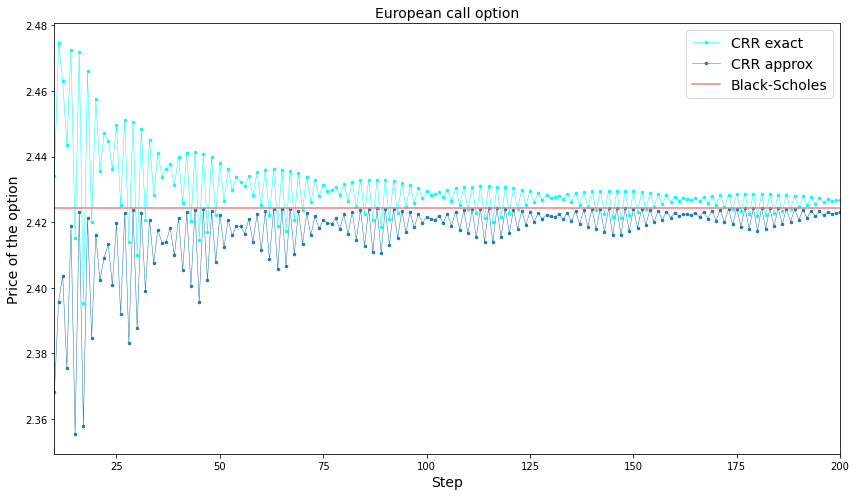

In [42]:
plt.figure(figsize=(12,7))
plt.plot(N_vals, crr_prices_exact, label='CRR exact', marker='.', lw=0.5, markersize=5, color='aqua')
plt.plot(N_vals, crr_approx_prices, label = 'CRR approx', marker='.', lw=0.5, markersize=5)
plt.axhline(y=bs_price, color='lightcoral', linestyle='-', label='Black-Scholes')
plt.title('European call option', fontsize=14)
plt.ylabel('Price of the option', fontsize=14)
plt.xlabel('Step', fontsize=14)
plt.legend(fontsize=14)
plt.xlim(10, 200)
plt.tight_layout()
plt.show()

### American put option ($S_0 = 70$, $K=70$, $r=0.05$, $\sigma=0.25$, $T=0.25$)

In [46]:
r = 0.05
sigma = 0.25
T = 0.25
S_0 = 70
K = 70
N_vals = np.arange(5, 201, 1)

In [47]:
%%time
crr_prices_exact_amer_put = [CRR_tree(r, sigma, K, T, N, S_0, option='American', option_type='put', exact=True) for N in N_vals]
crr_prices_apprrox_amer_put = [CRR_tree(r, sigma, K, T, N, S_0, option='American', option_type='put', exact=False) for N in N_vals]

Wall time: 37.3 s


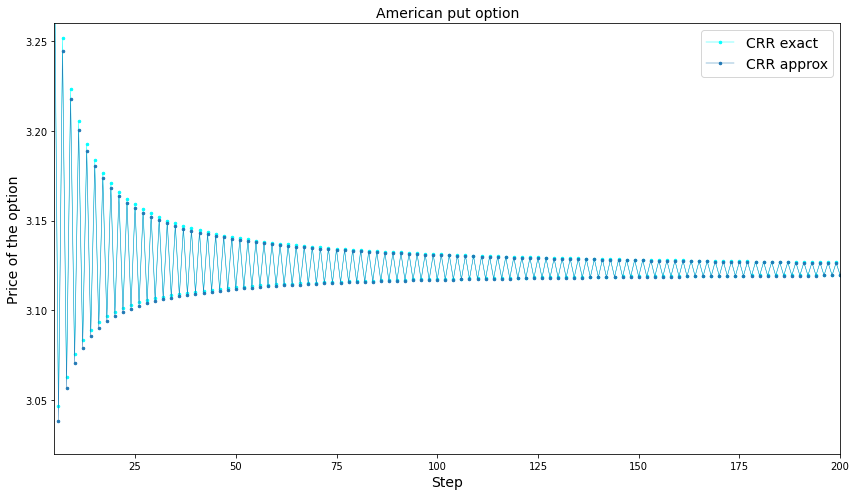

In [48]:
plt.figure(figsize=(12,7))
plt.plot(N_vals, crr_prices_exact_amer_put, label='CRR exact', marker='.', lw=0.45, markersize=5, color='aqua')
plt.plot(N_vals, crr_prices_apprrox_amer_put, label = 'CRR approx', marker='.', lw=0.45, markersize=5)
plt.title('American put option', fontsize=14)
plt.ylabel('Price of the option', fontsize=14)
plt.xlabel('Step', fontsize=14)
plt.legend(fontsize=14)
plt.ylim(3.02, 3.26)
plt.xlim(5, 200)
plt.tight_layout()
plt.show()

### European put option ($S_0 = 55$, $K=50$, $r=0.05$, $\sigma=0.1$, $T=2$)

In [46]:
r = 0.05
sigma = 0.1
T = 2
S_0 = 55
K = 50
N_vals = np.arange(10, 301, 1)

In [47]:
%%time
crr_put_prices_exact = [CRR_tree(r, sigma, K, T, N, S_0, option='European', option_type='put', exact=True) for N in N_vals]
crr_put_prices_approx = [CRR_tree(r, sigma, K, T, N, S_0, option='European', option_type='put', exact=False) for N in N_vals]
bs_price_put = v_price(S_0, K, r, sigma, T, 0, call=False)

Wall time: 30.9 s


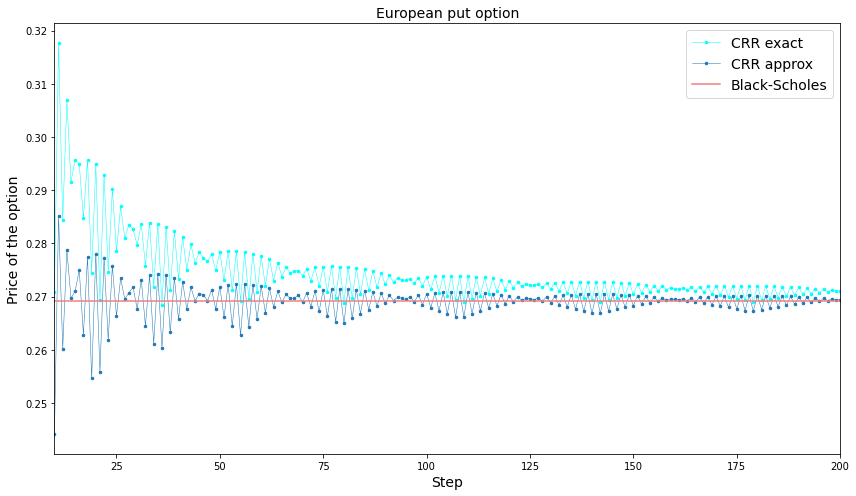

In [48]:
plt.figure(figsize=(12,7))
plt.plot(N_vals, crr_put_prices_exact, label='CRR exact', marker='.', lw=0.5, markersize=5, color='aqua')
plt.plot(N_vals, crr_put_prices_approx, label = 'CRR approx', marker='.', lw=0.5, markersize=5)
plt.axhline(y=bs_price_put, color='lightcoral', linestyle='-', label='Black-Scholes')
plt.title('European put option', fontsize=14)
plt.ylabel('Price of the option', fontsize=14)
plt.xlabel('Step', fontsize=14)
plt.legend(fontsize=14)
plt.xlim(10, 200)
plt.tight_layout()
plt.show()

### European call option ($S_0 = 55$,$K=70$, $r=0.1$, $T=2$, $\sigma = 0.05$)

In [49]:
r = 0.1
sigma = 0.05
T = 2
S_0 = 55
K = 70
N_vals = np.arange(10, 301, 1)

In [50]:
crr_call_prices_exact = [CRR_tree(r, sigma, K, T, N, S_0, option='European', option_type='call', exact=True) for N in N_vals]
crr_call_prices_approx = [CRR_tree(r, sigma, K, T, N, S_0, option='European', option_type='call', exact=False) for N in N_vals]
bs_price_call = v_price(S_0, K, r, sigma, T, 0)

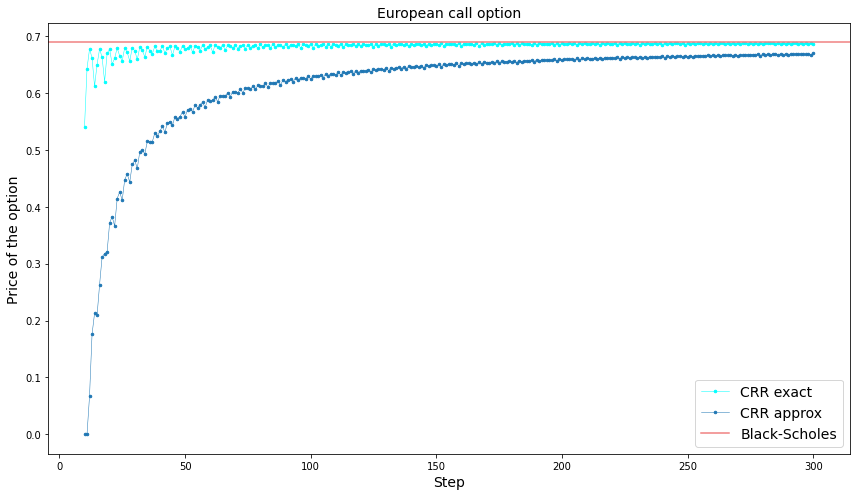

In [51]:
plt.figure(figsize=(12,7))
plt.plot(N_vals, crr_call_prices_exact, label='CRR exact', marker='.', lw=0.5, markersize=5, color='aqua')
plt.plot(N_vals, crr_call_prices_approx, label = 'CRR approx', marker='.', lw=0.5, markersize=5)
plt.axhline(y=bs_price_call, color='lightcoral', linestyle='-', label='Black-Scholes')
plt.title('European call option', fontsize=14)
plt.ylabel('Price of the option', fontsize=14)
plt.xlabel('Step', fontsize=14)
plt.legend(fontsize='14')
plt.tight_layout()
plt.show()

### European put option ($S_0=70$, $K=70$, $r=0.05$, $\sigma=0.25$, $T=0.25$)

In [52]:
r = 0.05
sigma = 0.25
T = 0.25
S_0 = 70
K = 70
N_vals = np.arange(10, 301, 1)

In [53]:
crr_put_prices_exact_diff_par = [CRR_tree(r, sigma, K, T, N, S_0, option='European', option_type='put', exact=True) for N in N_vals]
crr_put_prices_approx_diff_par = [CRR_tree(r, sigma, K, T, N, S_0, option='European', option_type='put', exact=False) for N in N_vals]
bs_price_put_diff_param = v_price(S_0, K, r, sigma, T, 0, call=False)

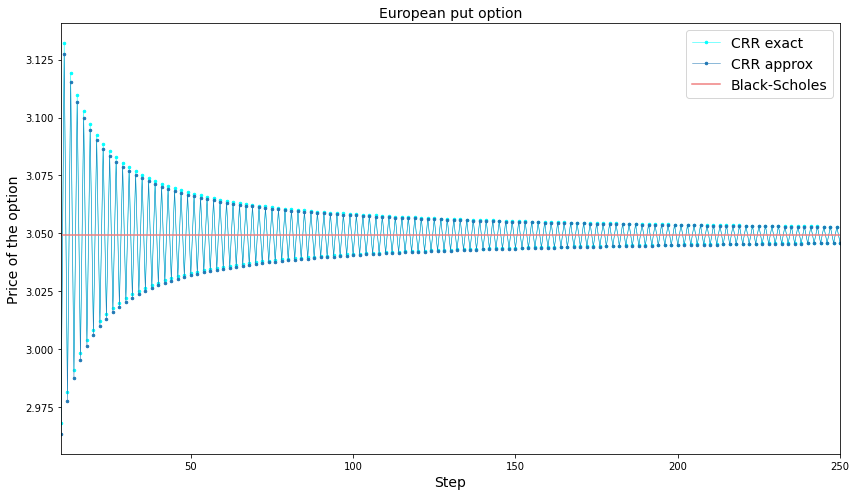

In [54]:
plt.figure(figsize=(12,7))
plt.plot(N_vals, crr_put_prices_exact_diff_par, label='CRR exact', marker='.', lw=0.5, markersize=5, color='aqua')
plt.plot(N_vals, crr_put_prices_approx_diff_par, label = 'CRR approx', marker='.', lw=0.5, markersize=5)
plt.axhline(y=bs_price_put_diff_param, color='lightcoral', linestyle='-', label='Black-Scholes')
plt.title('European put option', fontsize=14)
plt.ylabel('Price of the option', fontsize=14)
plt.xlabel('Step', fontsize=14)
plt.legend(fontsize=14)
plt.xlim(10, 250)
plt.tight_layout()
plt.show()

## JR tree - probabilities

In [55]:
def up_down_JR_exact_and_approx(r, sigma, T, N, exact=True):
    dt = T / N
    if exact:
        u = np.exp(r*dt) * (1 + np.sqrt(np.exp(sigma**2 * dt) - 1))
        d = np.exp(r*dt) * (1 - np.sqrt(np.exp(sigma**2 * dt) - 1))
    else:
        u = np.exp((r -  0.5 * sigma**2) * dt + sigma * np.sqrt(dt))
        d = np.exp((r -  0.5 * sigma**2) * dt - sigma * np.sqrt(dt))
        
    return u, d

## JR tree implementation

In [8]:
def JR_tree(r, sigma, K, T, N, S_0, option, option_type, exact=True):
    dt = T / N
    u, d = up_down_JR_exact_and_approx(r, sigma, T, N, exact)

    S = np.zeros((N + 1, N + 1)) #underlying prices
    for j in range(N + 1):
        for i in range(j + 1):
            S[i, j] = S_0 * u**(j - i) * d**(i)
    
    value_jr = np.zeros((N + 1, N + 1))
    for i in range(N + 1): #payoff at maturity
        if option_type == 'call':
            value_jr[i, N] = np.maximum(S[i, N] - K, 0)
        elif option_type == 'put':
            value_jr[i, N] = np.maximum(K - S[i, N], 0)
        
    for j in range(N - 1, -1, -1): #move backwards through the tree
        for i in range(j + 1): 
            if option == 'American':
                if option_type == 'call': 
                    exercise_value = np.maximum(S[i, j] - K, 0)
                    binomial_option_value = np.exp(-r * dt) * (0.5 * value_jr[i, j+1] + (1 - 0.5) * value_jr[i+1, j+1])
                    value_jr[i, j] = np.maximum(binomial_option_value, exercise_value)
                elif option_type == 'put':
                    exercise_value = np.maximum(K - S[i, j], 0)
                    binomial_option_value = np.exp(-r * dt) * (0.5 * value_jr[i, j+1] + (1 - 0.5) * value_jr[i+1, j+1])
                    value_jr[i, j] = np.maximum(binomial_option_value, exercise_value)
            if option == 'European':
                value_jr[i, j] = np.exp(-r * dt) * (0.5 * value_jr[i, j+1] + (1 - 0.5) * value_jr[i+1, j+1])
        
    return value_jr[0, 0]

### European call option($S_0 = 45$, $K=50$, $r=0.05$, $\sigma=0.1$, $T=2$)

In [57]:
r = 0.05
sigma = 0.1
T = 2
S_0 = 45
K = 50
N_vals = np.arange(10, 301, 1)

In [58]:
jr_prices_exact = [JR_tree(r, sigma, K, T, N, S_0, option='European', option_type='call', exact=True) for N in N_vals]
jr_prices_approx = [JR_tree(r, sigma, K, T, N, S_0, option='European', option_type='call', exact=False) for N in N_vals]
bs_price = v_price(S_0, K, r, sigma, T, 0)

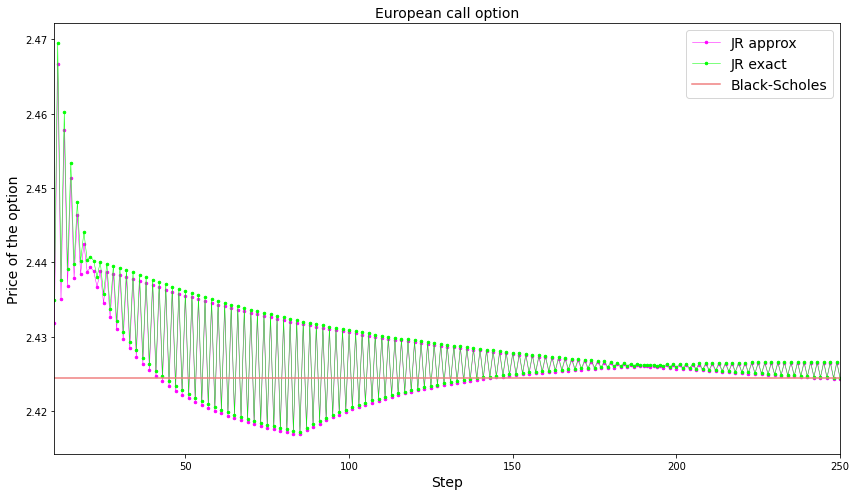

In [59]:
plt.figure(figsize=(12,7))
plt.plot(N_vals, jr_prices_approx, label = 'JR approx', marker='.', lw=0.5, markersize=5, color='fuchsia')
plt.plot(N_vals, jr_prices_exact, label = 'JR exact', marker='.', lw=0.5, markersize=5, color='lime')
plt.axhline(y=bs_price, color='lightcoral', linestyle='-', label='Black-Scholes')
plt.title('European call option', fontsize=14)
plt.ylabel('Price of the option', fontsize=14)
plt.xlabel('Step', fontsize=14)
plt.legend(fontsize=14)
plt.xlim(10, 250)
plt.tight_layout()
plt.show()

### European put ($S_0 = 55$, $K=50$, $r=0.05$, $\sigma=0.1$, $T=2$)

In [60]:
r = 0.05
sigma = 0.1
T = 2
S_0 = 55
K = 50
N_vals = np.arange(10, 301, 1)

In [61]:
jr_put_prices_exact = [JR_tree(r, sigma, K, T, N, S_0, option='European', option_type='put', exact=True) for N in N_vals]
jr_put_prices_approx = [JR_tree(r, sigma, K, T, N, S_0, option='European', option_type='put', exact=False) for N in N_vals]
bs_price_put_jr = v_price(S_0, K, r, sigma, T, 0, call=False)

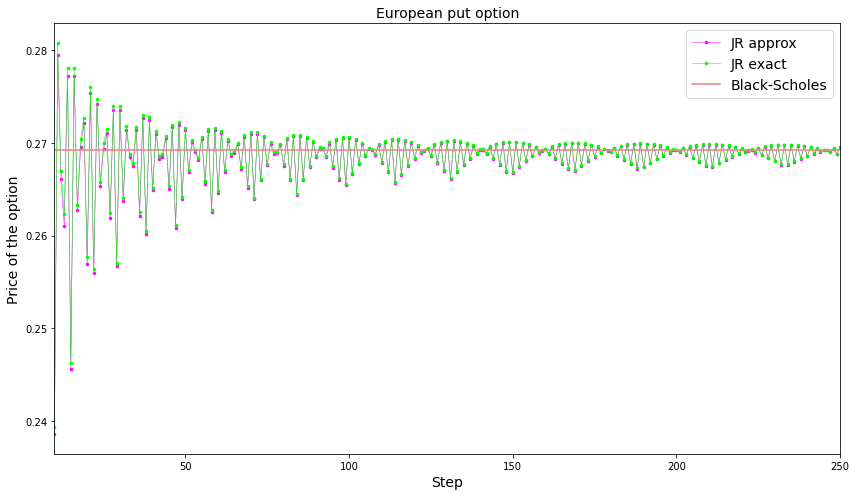

In [62]:
plt.figure(figsize=(12,7))
plt.plot(N_vals, jr_put_prices_approx, label = 'JR approx', marker='.', lw=0.5, markersize=5, color='fuchsia')
plt.plot(N_vals, jr_put_prices_exact, label='JR exact', marker='.', lw=0.5, markersize=5, color='lime')
plt.axhline(y=bs_price_put_jr, color='lightcoral', linestyle='-', label='Black-Scholes')
plt.title('European put option', fontsize=14)
plt.ylabel('Price of the option', fontsize=14)
plt.xlabel('Step', fontsize=14)
plt.legend(fontsize=14)
plt.xlim(10, 250)
plt.tight_layout()
plt.show()

### American put option

In [107]:
r = 0.05
sigma = 0.25
T = 0.25
S_0 = 70
K = 70
N_vals = np.arange(5, 201, 1)

jr_amer_put_prices_exact = [JR_tree(r, sigma, K, T, N, S_0, option='American', option_type='put', exact=True) for N in N_vals]
jr_amer_put_prices_approx = [JR_tree(r, sigma, K, T, N, S_0, option='American', option_type='put', exact=False) for N in N_vals]

### European call ($S_0 = 55$, $K=70$, $r=0.1$, $\sigma=0.05$, $T=2$)

In [64]:
r = 0.1
sigma = 0.05
T = 2
S_0 = 55
K = 70
N_vals = np.arange(10, 301, 1)

jr_eur_call_prices_exact = [JR_tree(r, sigma, K, T, N, S_0, option='European', option_type='call', exact=True) for N in N_vals]
jr_eur_call_prices_approx = [JR_tree(r, sigma, K, T, N, S_0, option='European', option_type='call', exact=False) for N in N_vals]

### European put option ($S_0 = 55$, $K=50$, $r=0.05$, $\sigma=0.1$, $T=2$)

In [65]:
r = 0.05
sigma = 0.1
T = 2
S_0 = 55
K = 50
N_vals = np.arange(10, 301, 1)

jr_eur_put_prices_exact = [JR_tree(r, sigma, K, T, N, S_0, option='European', option_type='put', exact=True) for N in N_vals]
jr_eur_put_prices_approx = [JR_tree(r, sigma, K, T, N, S_0, option='European', option_type='put', exact=False) for N in N_vals]

### European put option ($S_0=70$, $K=70$, $r=0.05$, $\sigma=0.25$, $T=0.25$)

In [66]:
r = 0.05
sigma = 0.25
T = 0.25
S_0 = 70
K = 70
N_vals = np.arange(10, 301, 1)

jr_eur_put_prices_exact_S0_equal_K = [JR_tree(r, sigma, K, T, N, S_0, option='European', option_type='put', exact=True) for N in N_vals]
jr_eur_put_prices_approx_S0_equal_K = [JR_tree(r, sigma, K, T, N, S_0, option='European', option_type='put', exact=False) for N in N_vals]

## Results on one plot

### European call option($S_0 = 45$, $K=50$, $r=0.05$, $\sigma=0.1$, $T=2$)

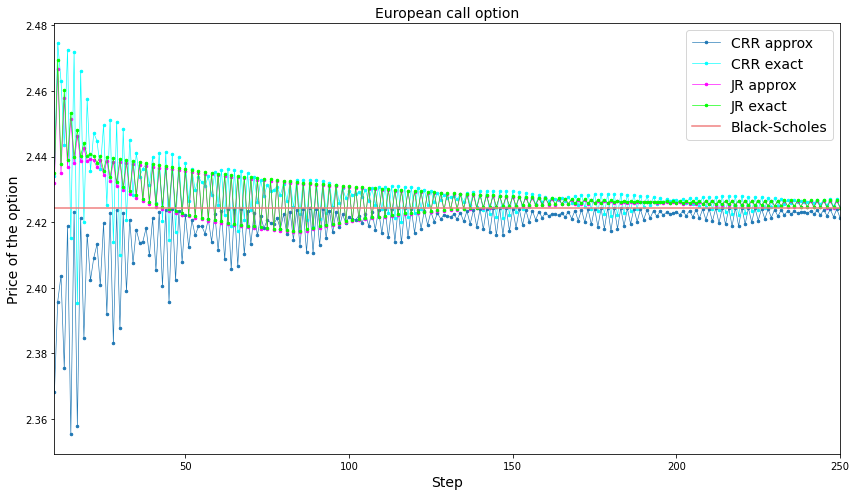

In [67]:
plt.figure(figsize=(12,7))
plt.plot(N_vals, crr_approx_prices, label = 'CRR approx', marker='.', lw=0.65, markersize=5)
plt.plot(N_vals, crr_prices_exact, label='CRR exact', marker='.', lw=0.65, markersize=5, color='aqua')
plt.plot(N_vals, jr_prices_approx, label = 'JR approx', marker='.', lw=0.65, markersize=5, color='fuchsia')
plt.plot(N_vals, jr_prices_exact, label='JR exact', marker='.', lw=0.65, markersize=5, color='lime')
plt.axhline(y=bs_price, color='lightcoral', linestyle='-', label='Black-Scholes')
plt.title('European call option', fontsize=14)
plt.ylabel('Price of the option', fontsize=14)
plt.xlabel('Step', fontsize=14)
plt.xlim(10, 250)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

### American put option ($S_0 = 70$, $K=70$, $r=0.05$, $\sigma=0.25$, $T=0.25$)

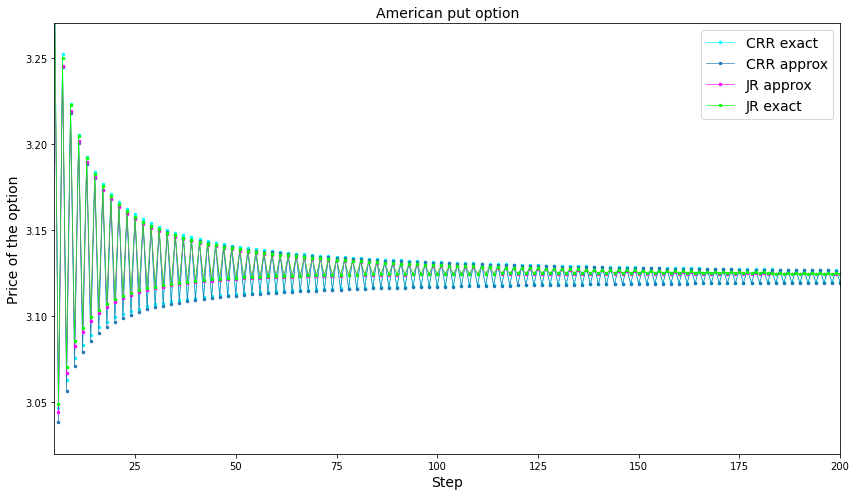

In [108]:
plt.figure(figsize=(12,7))
plt.plot(N_vals, crr_prices_exact_amer_put, label='CRR exact', marker='.', lw=0.65, markersize=5, color='aqua')
plt.plot(N_vals, crr_prices_apprrox_amer_put, label = 'CRR approx', marker='.', lw=0.65, markersize=5)
plt.plot(N_vals, jr_amer_put_prices_approx, label = 'JR approx', marker='.', lw=0.65, markersize=5, color='fuchsia')
plt.plot(N_vals, jr_amer_put_prices_exact, label='JR exact', marker='.', lw=0.65, markersize=5, color='lime')
plt.title('American put option', fontsize=14)
plt.ylabel('Price of the option', fontsize=14)
plt.xlabel('Step', fontsize=14)
plt.legend(fontsize=14)
plt.xlim(5, 200)
plt.ylim(3.02, 3.27)
plt.tight_layout()
plt.show()

### European call option ($S_0 = 55$,$K=70$, $r=0.1$, $T=2$, $\sigma = 0.05$)

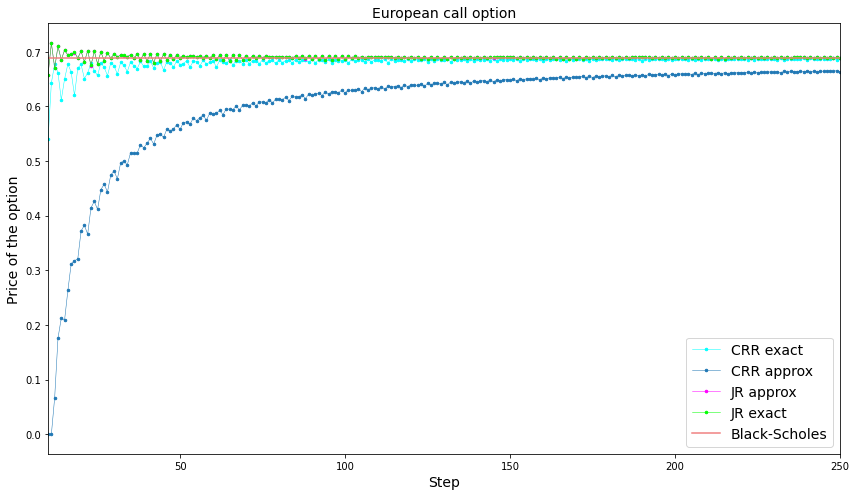

In [69]:
plt.figure(figsize=(12,7))
plt.plot(N_vals, crr_call_prices_exact, label='CRR exact', marker='.', lw=0.5, markersize=5, color='aqua')
plt.plot(N_vals, crr_call_prices_approx, label = 'CRR approx', marker='.', lw=0.5, markersize=5)
plt.plot(N_vals, jr_eur_call_prices_approx, label = 'JR approx', marker='.', lw=0.5, markersize=5, color='fuchsia')
plt.plot(N_vals, jr_eur_call_prices_exact, label='JR exact', marker='.', lw=0.5, markersize=5, color='lime')
plt.axhline(y=bs_price_call, color='lightcoral', linestyle='-', label='Black-Scholes')
plt.title('European call option', fontsize=14)
plt.ylabel('Price of the option', fontsize=14)
plt.xlabel('Step', fontsize=14)
plt.legend(fontsize='14')
plt.xlim(10, 250)
plt.tight_layout()
plt.show()

### European put option ($S_0 = 55$, $K=50$, $r=0.05$, $\sigma=0.1$, $T=2$)

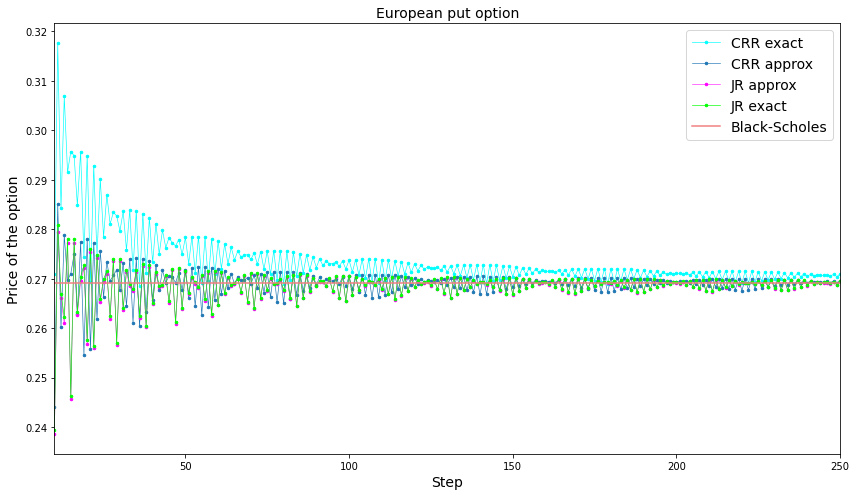

In [70]:
plt.figure(figsize=(12,7))
plt.plot(N_vals, crr_put_prices_exact, label='CRR exact', marker='.', lw=0.65, markersize=5, color='aqua')
plt.plot(N_vals, crr_put_prices_approx, label = 'CRR approx', marker='.', lw=0.65, markersize=5)
plt.plot(N_vals, jr_eur_put_prices_approx, label = 'JR approx', marker='.', lw=0.55, markersize=5, color='fuchsia')
plt.plot(N_vals, jr_eur_put_prices_exact, label='JR exact', marker='.', lw=0.65, markersize=5, color='lime')
plt.axhline(y=bs_price_put, color='lightcoral', linestyle='-', label='Black-Scholes')
plt.title('European put option', fontsize=14)
plt.ylabel('Price of the option', fontsize=14)
plt.xlabel('Step', fontsize=14)
plt.legend(fontsize=14)
plt.xlim(10, 250)
plt.tight_layout()
plt.show()

### European put option ($S_0 = 70$, $K=70$, $r=0.05$, $\sigma=0.25$, $T=0.25$)

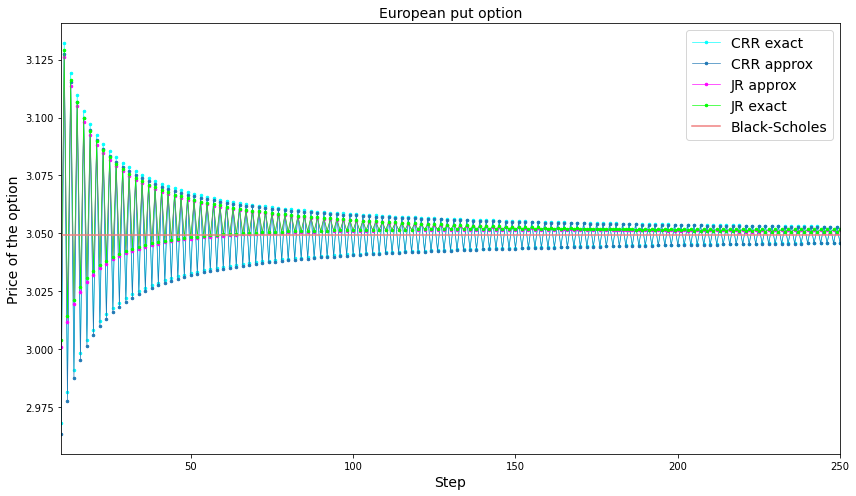

In [71]:
plt.figure(figsize=(12,7))
plt.plot(N_vals, crr_put_prices_exact_diff_par, label='CRR exact', marker='.', lw=0.65, markersize=5, color='aqua')
plt.plot(N_vals, crr_put_prices_approx_diff_par, label = 'CRR approx', marker='.', lw=0.65, markersize=5)
plt.plot(N_vals, jr_eur_put_prices_approx_S0_equal_K, label = 'JR approx', marker='.', lw=0.65, markersize=5, color='fuchsia')
plt.plot(N_vals, jr_eur_put_prices_exact_S0_equal_K, label='JR exact', marker='.', lw=0.65, markersize=5, color='lime')
plt.axhline(y=bs_price_put_diff_param, color='lightcoral', linestyle='-', label='Black-Scholes')
plt.title('European put option', fontsize=14)
plt.ylabel('Price of the option', fontsize=14)
plt.xlabel('Step', fontsize=14)
plt.legend(fontsize=14)
plt.xlim(10, 250)
plt.tight_layout()
plt.show()

# Trinomial trees

## Boyle probabilities

In [72]:
def trinomial_trees_probs_boyle(r, sigma, lamb, T, N):
    dt = T / N
    u = np.exp((lamb * sigma) * np.sqrt(dt))
    q_u = ((np.exp((2*r + sigma**2) * dt) - np.exp(r*dt)) * u - (np.exp(r*dt) - 1)) / ((u - 1) * (u**2 - 1))
    d = 1 / u
    q_d = ((np.exp((2*r + sigma**2) * dt) - np.exp(r*dt)) * u**2 - (np.exp(r*dt) - 1) * u**3) / ((u - 1) * (u**2 - 1))
    q_m = 1 - q_u - q_d
    return q_u, q_d, q_m

## Boyle tree implementation

In [73]:
def boyle_tree(r, sigma, lamb, K, T, N, S_0, option, option_type):
    dt = T / N
    u = np.exp((lamb * sigma) * np.sqrt(dt))
    d = 1 / u
    q_u, q_d, q_m = trinomial_trees_probs_boyle(r, sigma, lamb, T, N)

    S = np.zeros((2*N + 1, N+1))
    for j in range(N + 1):
        for i in range(2 * j + 1):
            S[i, j] = S_0 * u**(j-i)
            
    option_value = np.zeros((2*N + 1, N + 1))
    for i in range(2*N + 1): 
        if option_type == 'call':
            option_value[i, N] = np.maximum(S[i, N] - K, 0)
        elif option_type == 'put':
            option_value[i, N] = np.maximum(K - S[i, N], 0)
            
    for j in range(N - 1, -1, -1):
        for i in range(2 * j + 1):
            if option == 'European':
                option_value[i, j] = np.exp(-r * dt) * (q_u * option_value[i, j+1] + 
                                                        q_m * option_value[i+1, j+1] + 
                                                        q_d * option_value[i+2, j+1])
            if option == 'American':
                if option_type == 'call':
                    option_value[i, j] = np.maximum(S[i, j] - K, np.exp(-r*dt) * (q_u * option_value[i, j+1] + 
                                                                                  q_m * option_value[i+1, j+1] +
                                                                                  q_d * option_value[i+2, j+1]))
                elif option_type == 'put':
                    option_value[i, j] = np.maximum(K - S[i, j], np.exp(-r*dt) * (q_u * option_value[i, j+1] + 
                                                                                  q_m * option_value[i+1, j+1] + 
                                                                                  q_d * option_value[i+2, j+1]))
                    
    return option_value[0, 0]

### European put option ($S_0=102$, $K=100$, $r=0.1$, $\sigma=0.2$, $T=0.25$)

In [74]:
S_0 = 102
K = 100
r = 0.1
sigma = 0.2
T = 0.25
lamb = 1.225
N_vals = np.arange(1, 201, 1)

In [75]:
%%time
boyle_eur_put = [boyle_tree(r, sigma, lamb, K, T, N, S_0, option='European', option_type='put') for N in N_vals]
bs_price_put_trinomial = v_price(S_0, K, r, sigma, T, 0, call=False)

Wall time: 6.33 s


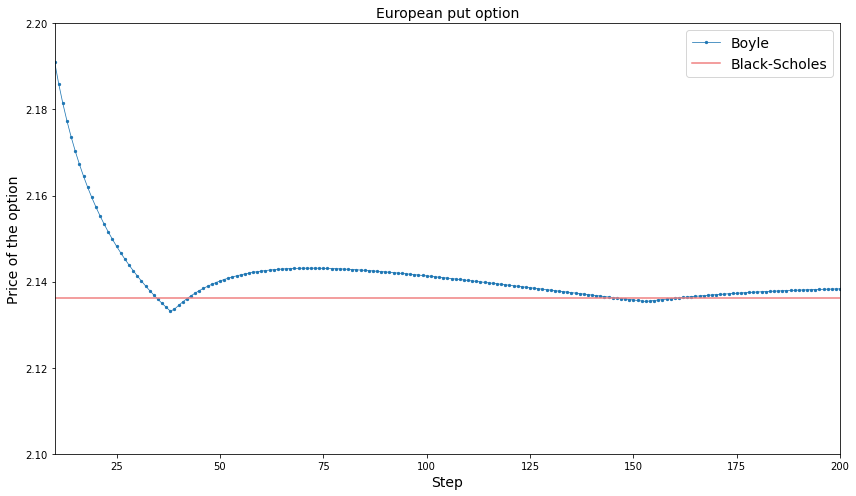

In [76]:
plt.figure(figsize=(12,7))
plt.plot(N_vals, boyle_eur_put, label='Boyle', marker='.', lw=0.75, markersize=4.5)
plt.axhline(y=bs_price_put_trinomial, color='lightcoral', linestyle='-', label='Black-Scholes')
plt.title('European put option', fontsize=14)
plt.ylabel('Price of the option', fontsize=14)
plt.xlabel('Step', fontsize=14)
plt.legend(fontsize=14)
plt.xlim(10, 200)
plt.ylim(2.10, 2.20)
plt.tight_layout()
plt.show()

### European put option ($S_0=45$, $K=50$, $r=0.05$, $\sigma=0.1$, $T=2$)

In [77]:
S_0 = 45
K = 50
r = 0.05
sigma = 0.1
T = 2
lamb = np.sqrt(3/2)
N_vals = np.arange(1, 201, 1)

In [78]:
%%time
boyle_eur_call_to_previous_mod_params = [boyle_tree(r, sigma, lamb, K, T, N, S_0, option ='European', option_type='call') for N in N_vals]
bs_price_call_trinomial_dif_params = v_price(S_0, K, r, sigma, T, 0)

Wall time: 7.12 s


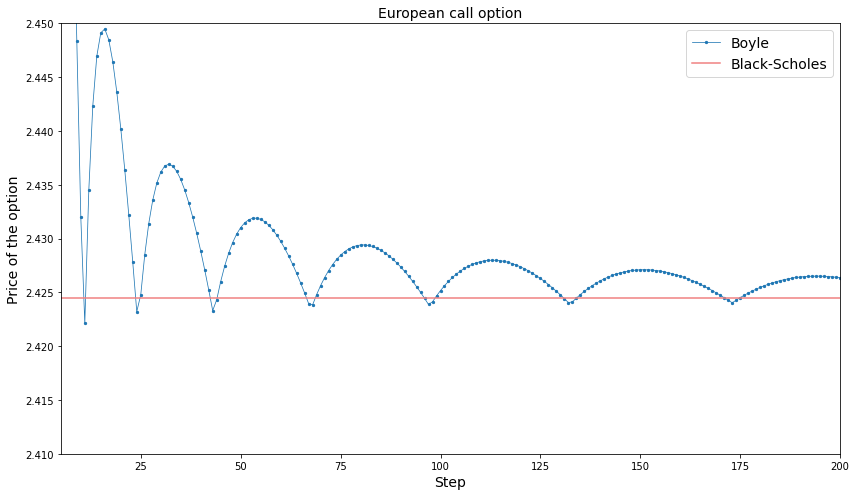

In [79]:
plt.figure(figsize=(12,7))
plt.plot(N_vals, boyle_eur_call_to_previous_mod_params, label='Boyle', marker='.', lw=0.75, markersize=4.5)
plt.axhline(y=bs_price_call_trinomial_dif_params, color='lightcoral', linestyle='-', label='Black-Scholes')
plt.title('European call option', fontsize=14)
plt.ylabel('Price of the option', fontsize=14)
plt.xlabel('Step', fontsize=14)
plt.legend(fontsize=14)
plt.xlim(5, 200)
plt.ylim(2.41, 2.45)
plt.tight_layout()
plt.show()

### European call option ($S_0=100$, $K=123$, $r=0.42$, $\sigma=0.1$, $T=1$)

In [80]:
S_0 = 100
K = 123
r = 0.42
sigma = 0.1
T = 1
lamb = np.sqrt(3/2)
N_vals = np.arange(1, 301, 1)

In [81]:
%%time
boyle_eur_call_diff_params = [boyle_tree(r, sigma, lamb, K, T, N, S_0, option='European', option_type='call') for N in N_vals]
bs_price_call_trinomial_dif_params_2 = v_price(S_0, K, r, sigma, T, 0)

Wall time: 7.6 s


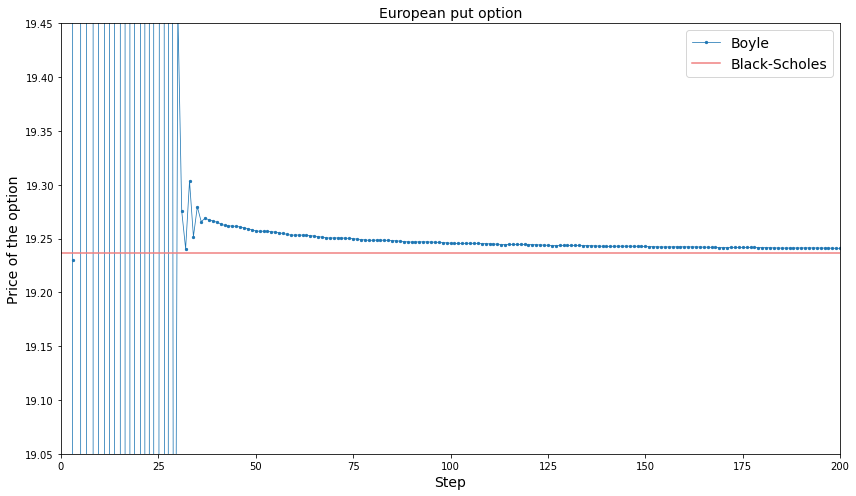

In [82]:
plt.figure(figsize=(12,7))
plt.plot(N_vals, boyle_eur_call_diff_params, label='Boyle', marker='.', lw=0.75, markersize=4.5)
plt.axhline(y=bs_price_call_trinomial_dif_params_2, color='lightcoral', linestyle='-', label='Black-Scholes')
plt.title('European put option', fontsize=14)
plt.ylabel('Price of the option', fontsize=14)
plt.xlabel('Step', fontsize=14)
plt.legend(fontsize=14)
plt.ylim(19.05,19.45)
plt.xlim(0, 200)
plt.tight_layout()
plt.show()

### American put option ($S_0=102$, $K=100$, $r=0.1$, $\sigma=0.2$, $T=0.25$)

In [83]:
S_0 = 102
K = 100
r = 0.1
sigma = 0.2
T = 0.25
lamb = 1.225
N_vals = np.arange(1, 201, 1)

In [84]:
%%time
boyle_amer_put = [boyle_tree(r, sigma, lamb, K, T, N, S_0, option='American', option_type='put') for N in N_vals]

Wall time: 14 s


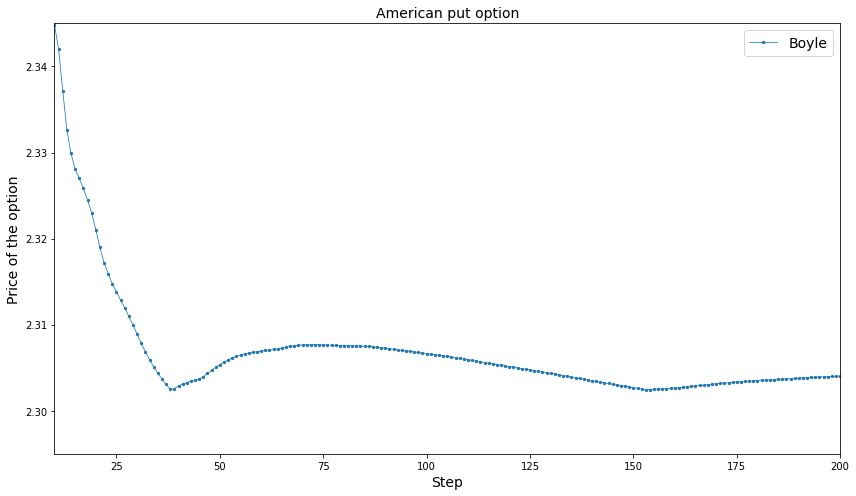

In [85]:
plt.figure(figsize=(12,7))
plt.plot(N_vals, boyle_amer_put, label='Boyle', marker='.', lw=0.75, markersize=4.5)
plt.title('American put option', fontsize=14)
plt.ylabel('Price of the option', fontsize=14)
plt.xlabel('Step', fontsize=14)
plt.legend(fontsize=14)
plt.xlim(10, 300)
plt.ylim(2.295, 2.345)
plt.tight_layout()
plt.show()

## Kamrad-Ritchken trinomial trees - probabilities

In [86]:
def trinomial_trees_probs_kamrad_ritchken(r, sigma, lamb, T, N):
    dt = T / N
    q_u = 1  / (2 * lamb**2) + ((r - sigma**2/2) * np.sqrt(dt)) / (2 * lamb * sigma)
    q_d = 1  / (2 * lamb**2) - ((r - sigma**2/2) * np.sqrt(dt)) / (2 * lamb * sigma)
    q_m = 1 - q_u - q_d
    return q_u, q_d, q_m

## Kamrad-Ritchken implementation

In [87]:
def kamrad_ritchken_tree(r, sigma, lamb, K, T, N, S, option, option_type):
    dt = T / N
    u = np.exp((lamb * sigma) * np.sqrt(dt))
    d = 1 / u
    q_u, q_d, q_m = trinomial_trees_probs_kamrad_ritchken(r, sigma, lamb, T, N)
    
    S = np.zeros((2*N + 1, N+1))
    for j in range(N + 1):
        for i in range(2 * j + 1):
            S[i, j] = S_0 * u**(j-i)
            
    option_value = np.zeros((2*N + 1, N + 1))
    for i in range(2*N + 1): 
        if option_type == 'call':
            option_value[i, N] = np.maximum(S[i, N] - K, 0)
        elif option_type == 'put':
            option_value[i, N] = np.maximum(K - S[i, N], 0)
            
    for j in range(N - 1, -1, -1):
        for i in range(2 * j + 1):
            if option == 'European':
                option_value[i, j] = np.exp(-r * dt) * (q_u * option_value[i, j+1] + 
                                                        q_m * option_value[i+1, j+1] + 
                                                        q_d * option_value[i+2, j+1])
            if option == 'American':
                if option_type == 'call':
                    option_value[i, j] = np.maximum(S[i, j] - K, np.exp(-r*dt) * (q_u * option_value[i, j+1] + 
                                                                                  q_m * option_value[i+1, j+1] +
                                                                                  q_d * option_value[i+2, j+1]))
                elif option_type == 'put':
                    option_value[i, j] = np.maximum(K - S[i, j], np.exp(-r*dt) * (q_u * option_value[i, j+1] + 
                                                                                  q_m * option_value[i+1, j+1] + 
                                                                                  q_d * option_value[i+2, j+1]))
                    
    return option_value[0, 0]

### American put option ($S_0=102$, $K=100$, $r=0.1$, $\sigma=0.2$, $T=0.25$)

In [88]:
S_0 = 102
K = 100
r = 0.1
sigma = 0.2
T = 0.25
lamb = 1.225
N_vals = np.arange(1, 201, 1)

In [89]:
%%time
kamr_ritch_amer_put = [kamrad_ritchken_tree(r, sigma, lamb, K, T, N, S_0, option='American', option_type='put') for N in N_vals]

Wall time: 13.7 s


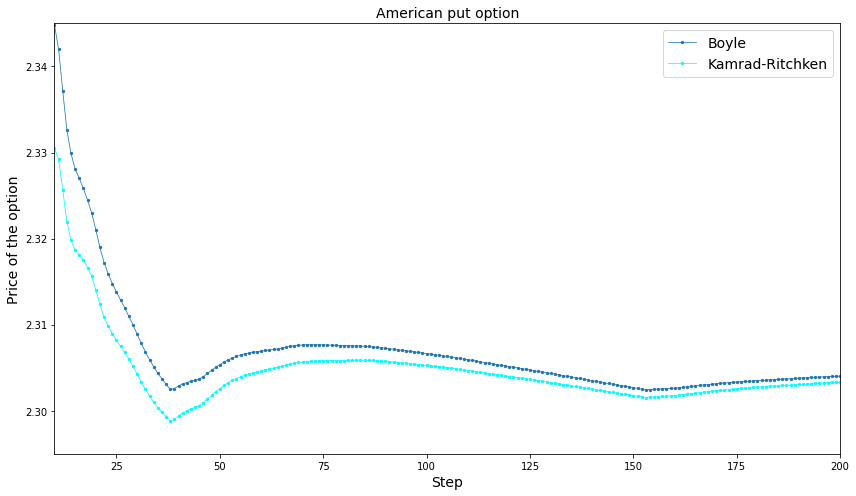

In [90]:
plt.figure(figsize=(12,7))
plt.plot(N_vals, boyle_amer_put, label='Boyle', marker='.', lw=0.75, markersize=4.5)
plt.plot(N_vals, kamr_ritch_amer_put, label='Kamrad-Ritchken', marker='.', lw=0.75, markersize=4.5, color='aqua')
plt.title('American put option', fontsize=14)
plt.ylabel('Price of the option', fontsize=14)
plt.xlabel('Step', fontsize=14)
plt.legend(fontsize=14)
plt.xlim(10,200)
plt.ylim(2.295, 2.345)
plt.tight_layout()
plt.show()

### European put option ($S_0=102$, $K=100$, $r=0.1$, $\sigma=0.2$, $T=0.25$)

In [91]:
S_0 = 102
K = 100
r = 0.1
sigma = 0.2
T = 0.25
lamb = 1.225
N_vals = np.arange(1, 201, 1)

In [92]:
%%time
kamr_ritch_eur_put = [kamrad_ritchken_tree(r, sigma, lamb, K, T, N, S_0, option='European', option_type='put') for N in N_vals]

Wall time: 7.61 s


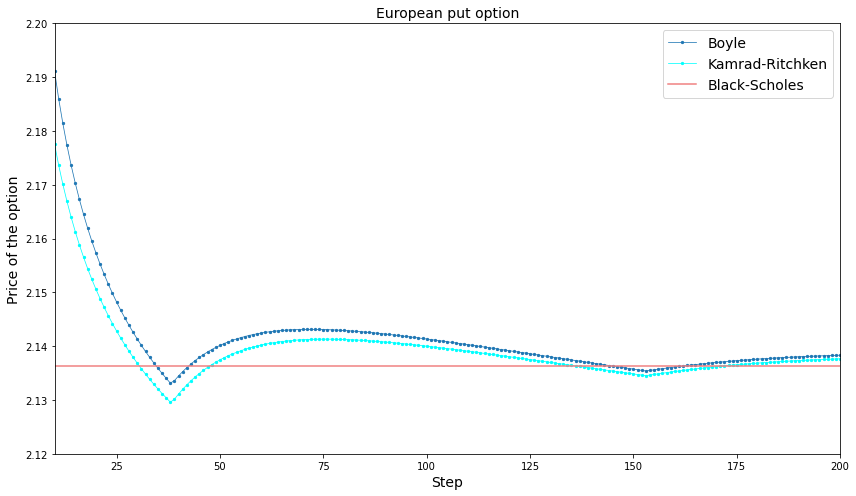

In [93]:
plt.figure(figsize=(12,7))
plt.plot(N_vals, boyle_eur_put, label='Boyle', marker='.', lw=0.75, markersize=4.5)
plt.plot(N_vals, kamr_ritch_eur_put, label='Kamrad-Ritchken', marker='.', lw=0.75, markersize=4.5, color='aqua')
plt.axhline(y=bs_price_put_trinomial, color='lightcoral', linestyle='-', label='Black-Scholes')
plt.title('European put option', fontsize=14)
plt.ylabel('Price of the option', fontsize=14)
plt.xlabel('Step', fontsize=14)
plt.legend(fontsize=14)
plt.ylim(2.12, 2.2)
plt.xlim(10,200)
plt.tight_layout()
plt.show()

### European call option ($S_0=45$, $K=50$, $r=0.05$, $\sigma=0.1$, $T=2$)

In [94]:
S_0 = 45
K = 50
r = 0.05
sigma = 0.1
T = 2
lamb = np.sqrt(3/2)
N_vals = np.arange(1, 201, 1)

In [95]:
%%time
bs_price_call_trinomial_dif_params = v_price(S_0, K, r, sigma, T, 0)
kamr_ritch_eur_call_diff_params = [kamrad_ritchken_tree(r, sigma, lamb, K, T, N, S_0, option='European', option_type='call') for N in N_vals]

Wall time: 8.23 s


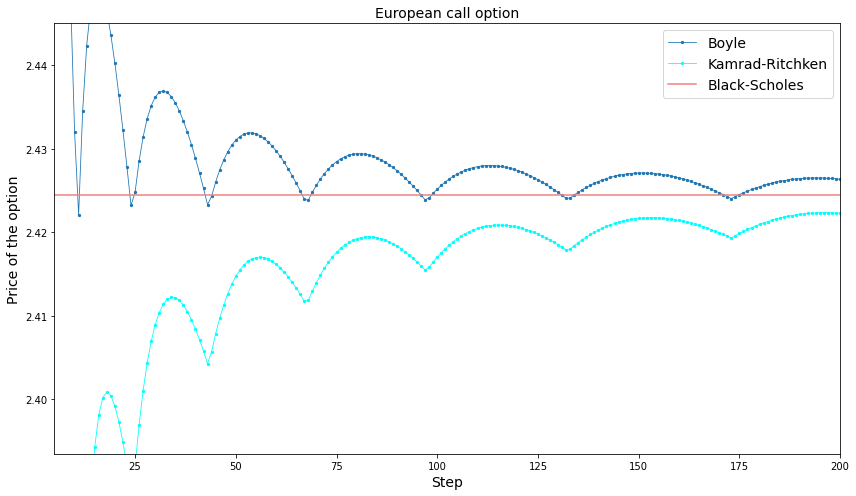

In [96]:
plt.figure(figsize=(12,7))
plt.plot(N_vals, boyle_eur_call_to_previous_mod_params, label='Boyle', marker='.', lw=0.8, markersize=4.5)
plt.plot(N_vals, kamr_ritch_eur_call_diff_params, label='Kamrad-Ritchken', marker='.', lw=0.8, markersize=4.5, color='aqua')
plt.axhline(y=bs_price_call_trinomial_dif_params, color='lightcoral', linestyle='-', label='Black-Scholes')
plt.title('European call option', fontsize=14)
plt.ylabel('Price of the option', fontsize=14)
plt.xlabel('Step', fontsize=14)
plt.legend(fontsize=14)
plt.ylim(2.3935, 2.445)
plt.xlim(5,200)
plt.tight_layout()
plt.show()

### European call option ($S_0=100$, $K=123$, $r=0.42$, $\sigma=0.1$, $T=1$)

In [97]:
S_0 = 100
K = 123
r = 0.42
sigma = 0.1
T = 1
lamb = np.sqrt(3/2)
N_vals = np.arange(1, 201, 1)

In [98]:
%%time
bs_price_call_trinomial_dif_params_2 = v_price(S_0, K, r, sigma, T, 0)
kamr_ritch_eur_call_last_example = [kamrad_ritchken_tree(r, sigma, lamb, K, T, N, S_0, option='European', option_type='call') for N in N_vals]

Wall time: 7.92 s


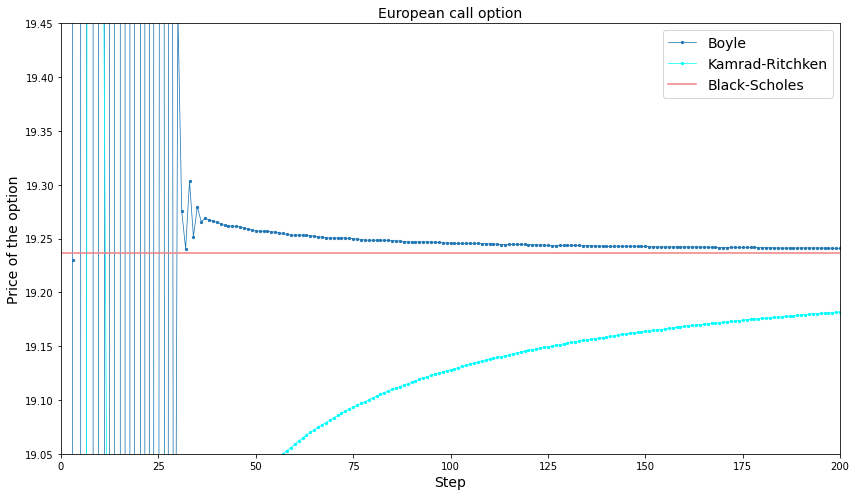

In [99]:
plt.figure(figsize=(12,7))
plt.plot(N_vals, boyle_eur_call_diff_params, label='Boyle', marker='.', lw=0.75, markersize=4.5)
plt.plot(N_vals, kamr_ritch_eur_call_last_example, label='Kamrad-Ritchken', marker='.', lw=0.75, markersize=4.5, color='aqua')
plt.axhline(y=bs_price_call_trinomial_dif_params_2, color='lightcoral', linestyle='-', label='Black-Scholes')
plt.title('European call option', fontsize=14)
plt.ylabel('Price of the option', fontsize=14)
plt.xlabel('Step', fontsize=14)
plt.legend(fontsize=14)
plt.ylim(19.05,19.45)
plt.xlim(0, 200)
plt.tight_layout()
plt.show()